# Rain in Australia
### Predicting next-day rain in Australia using an LSTM Neural Network

A dataset from [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) </br>

### **Best achieved result: F1 score of 0.78**

</br>

### Contents

Project is split into two key pieces - data preparation and modelling.

**Data preparation notebook**
- does some data exploration,
- cleans up several variables,
- creates some new ones,
- imputes missing data,
- splits up data for train/test,
- scales the data

Extra care is taken to avoid any data leakage. Notebook runs once and saves the outputs as csvs.

**Data modelling notebook**
- reads in the cleaned csvs
- transforms the data into an appropriate shape for the model to read in
- throws it into a dataloader for batched processing
- sends the data through a training loop
- all of the metadata + artefacts (such as loss/accuracy curves) are stored in [Neptune](https://app.neptune.ai/vinas94/RainAustralia/experiments?split=tbl&dash=Dashboard-1c94a424-6e34-4147-b965-f54b9fe0bfde&viewId=fe1fb5c5-89b0-4603-8cb1-a773788aa13c)
- a number of custom functions and the LSTM model itself is stored in the `custom.py` script

</br>

### Report

**Motivation**  
This data is of a time series nature. It is reasonable to assume that the weather inhibits patterns over
several days therefore modelling this data with a model built for sequential data could work. A single
layer LSTM Neural Network is chosen as it is widely used and is often successful.

**Data transformation & LSTM settings**  
The data needs to be reshaped to fit the LSTM input requirements. First, the dataset is split by city.
Then, arrays of lenght 7 are created, containing the 7-day history of all 22 features prior to the target.
These arrays are then stacked into a tensor of shape [N, 7, 22] where N represents the total number of
observations. This is done for both training and test data.
The chosen LSTM architecture is simple - a single layer with 5 hidden nodes. The output then goes
through a ReLu activation function and finally into a dense linear layer with one output neuron. A
sigmoid function is then applied in order to get the prediction. Binary Cross Entropy is used as the loss
function for training. The network is trained for 500 epochs in batches of 128 while keeping track of the
loss values and the performance metrics.

**Results**  

There were 5 different model runs in total. Each run was a slight modification of the previous one in effort
to improve performance. Two of these runs (run 2 - the baseline and run 4 - best run) are described below.

#### Base run

<figure>
  <img src="./Plots/run2.png" alt="fig1"/>
  <figcaption>Figure 1: Base run using all data (run 2 from Neptune)</figcaption>
</figure>

The default network trained for the whole of 500 epochs though improvements were minimal past epoch 100.
While loss continued to decrease, the change in accuracy was negligible reaching 0.86 for test and 0.87
for training. Similarly, F1 score for test data kept oscillating past epoch 100 reaching an average of
0.77. However, while overall accuracy is reasonably high, the confusion matrix in Fig 1 indicates stark
differences in prediction performance for the majority/minority groups. Furthermore the classification
report in Table 1 shows that while the F1 score for the majority class was 0.91 it reached only 0.62 for
the minority group. Similarly, the recall rate for the minority class was very low at just 0.54 indicating
sub-optimal model performance.

                              precision    recall  f1-score   support  

                         0.0       0.88      0.95      0.91     31774  
                         1.0       0.74      0.54      0.62      8925  

                    accuracy                           0.86     40699  
                   macro avg       0.81      0.74      0.77     40699  
                weighted avg       0.85      0.86      0.85     40699
                
    Table 1: Classification report for the base run

The asymmetric performance was caused by significant class imbalance in the training data. Only
around 22% of observations belong to the positive group thus model performance is skewed. There
are two possible approaches to rectify this issue. One is to upsample the minority class by drawing
observations with replacement until class ratio equalises. Second is to add a weight on the minority class
in the loss function effectively penalising incorrect minority class predictions more. On this particular
problem both approaches gave comparable results. However, the upsampling method was significantly
slower to train as the data size grew by around 56%, thus, the loss weighting method was chosen instead.
    
#### Best run

<figure>
  <img src="./Plots/run4.png" alt="fig2"/>
  <figcaption>Figure 2: Run with a positive weight in the loss function (run 4 from Neptune)</figcaption>
</figure>

Key performance metrics of the retrained LSTM using a minority class weight of 2 are displayed in Fig 2. Similarly to the previous model, most of the training happened in the first 100 epochs. However, this
time, test data accuracy and loss curves are more volatile. The confusion matrix shows a significant
improvement for the minority class - 15p.p. increase in the true positive rate. Though that comes
at a cost of 7p.p. for the true negative rate. Classification report in Table 2 summarises the model
performance. The key metric - average F1 score - improved by 1p.p. Not a major improvement but still
welcoming. Most importantly though, the delta of the class conditional precision, recall and F1 scores
got smaller. F1 score for the minority group increased by 4p.p

                              precision    recall  f1-score   support  

                         0.0       0.91      0.88      0.90     31774  
                         1.0       0.63      0.69      0.66      8925  

                    accuracy                           0.84     40699  
                   macro avg       0.77      0.79      0.78     40699  
                weighted avg       0.85      0.84      0.85     40699
                
    Table 2: Classification report for the best run

</br>

## Loading libraries

In [1]:
# core
import os
import time
import pandas as pd
import numpy as np
import neptune.new as neptune
from tqdm import tqdm

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix

# torch
import torch
from torch import optim
from torch.utils.data import DataLoader

# custom functions
from custom import *
from imblearn.over_sampling import RandomOverSampler

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

</br>
</br>
</br>

## Setting up Neptune environment

In [2]:
run = neptune.init(
    run='WA-3',
#     name='run 3',
    project='vinas94/RainAustralia',
    api_token=os.popen('cat /home/vinas/.bashrc | egrep "NEPTUNE_API_TOKEN"').readlines()[0][26:-2],
#     source_files=['custom.py', 'main.ipynb']
)

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/vinas94/RainAustralia/e/WA-3


In [3]:
PARAMS = {
    'batch_size': 128,
    'n_days': 7,
    'epochs': 500,
    'lr': 0.001,
    'cities': [],
    'features': []
}

</br>
</br>
</br>

## Parsing and prepping the data

In [4]:
# Reading in the data
X_train, y_train = read_and_parse('train', cities=PARAMS['cities'], columns=PARAMS['features'])
X_test, y_test = read_and_parse('test', cities=PARAMS['cities'], columns=PARAMS['features'])

# Transforming data into input/output pairs
X_train, y_train = transform_to_TS(X_train, y_train, n=PARAMS['n_days'])
X_test, y_test = transform_to_TS(X_test, y_test, n=PARAMS['n_days'])

# Oversampling minority class
oversample = RandomOverSampler(sampling_strategy='minority')
_ = oversample.fit_resample(X_train[:,:,0], y_train)
X_train = X_train[oversample.sample_indices_]
y_train = y_train[oversample.sample_indices_]

# Creating torch class datasets
train_dataset = timeseries(X_train, y_train)
test_dataset = timeseries(X_test, y_test)

# # Setting up dataloaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=PARAMS['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=PARAMS['batch_size'])

</br>
</br>
</br>

## Setting up the model

In [5]:
r = torch.tensor(len(y_train)/y_train.sum()-1, dtype=torch.float32)
r -= 1.5 # biasing slightly towards precision
PARAMS['r'] = torch.tensor(1) # r
PARAMS['n_features'] = X_train.shape[2]

model = LSTM(PARAMS['n_features'])
loss = nn.BCEWithLogitsLoss(pos_weight=PARAMS['r']) # pos_weight > 1 will increase the recall while pos_weight < 1 will increase the precision.
optimiser = optim.Adam(model.parameters(), lr=PARAMS['lr'])
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.1, patience=10, verbose=True)

In [ ]:
run['params'] = PARAMS
run['model'] = {'model': model, 'loss': loss, 'optimiser': optimiser} # , 'scheduler': scheduler}

</br>
</br>
</br>

## Executing training loop

In [7]:
pbar = tqdm(range(PARAMS['epochs']))
for epoch in pbar:

    model.train()
    loss_tr = 0
    corr_tr = 0
    for data in train_loader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        L = loss(outputs, labels)
        L.backward()
        optimiser.step()

        # keep track of the loss and accuracy this epoch
        loss_tr += L.item()
        preds = torch.sigmoid(outputs).round()
        corr_tr += (preds==labels).sum().item()
        
#     scheduler.step(loss_tr)
#     run['artefacts/lr'].log(optimiser.param_groups[0]['lr'])
        
    acc_tr = corr_tr / train_loader.dataset.x.shape[0]
    loss_tr = loss_tr / (train_loader.dataset.x.shape[0] / test_loader.dataset.x.shape[0])
    
    # Rescaling to fit test data
    k = len(train_loader)/ (len(y_train)/len(y_test))
    loss_tr /= k
    
    run['artefacts/loss_tr'].log(loss_tr)
    run['artefacts/acc_tr'].log(acc_tr)
    
    
    model.eval()
    
    # test accuracy
    y_hat_test = get_predictions(X_test, model=model)
    acc_tt = accuracy_score(y_test, y_hat_test)
    run['artefacts/acc_tt'].log(acc_tt)
    
    run['artefacts/f1_scores'].log(f1_score(y_test, y_hat_test))
    run['artefacts/f1_scores_avg'].log(np.mean([f1_score(y_test, y_hat_test), f1_score(1-y_test, 1-y_hat_test)]))
    
    # test loss
    outputs = model(torch.tensor(X_test, dtype=torch.float32))
    loss_tt = loss(outputs, torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)).item()
    run['artefacts/loss_tt'].log(loss_tt)
    
    
    pbar.set_postfix({'test_accuracy': acc_tt,  'test_loss': loss_tt, 'train_accuracy': acc_tr, 'train_loss': loss_tr})

100%|██████████| 500/500 [38:47<00:00,  4.66s/it, test_accuracy=0.824, test_loss=0.39, train_accuracy=0.819, train_loss=0.395] 


In [8]:
# saving the model weights
torch.save(model.state_dict(), './weights.weights')
run['model/weights'].upload('./weights.weights')
run.wait()
os.remove('./weights.weights') 

</br>
</br>
</br>

## Loading the trained model and training summary

In [6]:
# recovering the model
run['model/weights'].download()
model = LSTM(PARAMS['n_features'])
model.load_state_dict(torch.load('./weights.weights'))
os.remove('./weights.weights')

In [7]:
# summarising artefacts in a dataframe
summary = pd.DataFrame(
    np.array([
        run['artefacts/acc_tt'].fetch_values()['value'].to_numpy(),
        run['artefacts/loss_tt'].fetch_values()['value'].to_numpy(),
        run['artefacts/acc_tr'].fetch_values()['value'].to_numpy(),
        run['artefacts/loss_tr'].fetch_values()['value'].to_numpy(),
        run['artefacts/f1_scores'].fetch_values()['value'].to_numpy(),
        run['artefacts/f1_scores_avg'].fetch_values()['value'].to_numpy()
    ]).T,
    columns=['accuracies_tt', 'losses_tt', 'accuracies_tr', 'losses_tr', 'f1_scores', 'f1_scores_avg']
)

</br>
</br>
</br>

## Preliminary visualisation

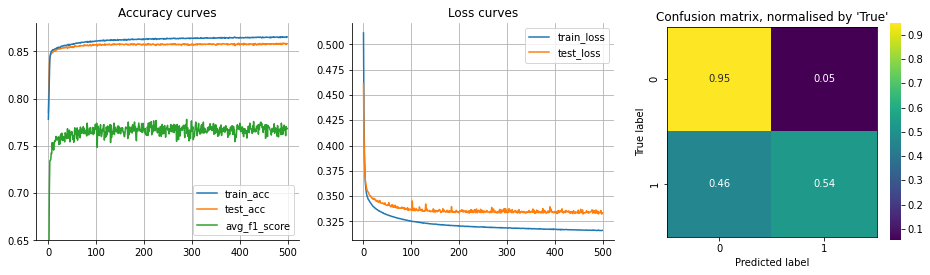

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

def reorderLegend(order, ax):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[i] for i in order], [labels[i] for i in order])
    
def left(ax=ax[0]):
    ax.plot(summary['accuracies_tt'], label='test_acc', color='#FF7F0E')
    ax.plot(summary['accuracies_tr'], label='train_acc', color='#1F77B4')
    ax.plot(summary['f1_scores_avg'], label='avg_f1_score', color='#2CA02C')
    reorderLegend([1, 0, 2], ax)
    ax.grid()
    ax.set_ylim([0.65, 0.88])
    ax.set_title('Accuracy curves')
    sns.despine(ax=ax)
    
    
def mid(ax=ax[1]):
    ax.plot(summary['losses_tr'], label='train_loss')
    ax.plot(summary['losses_tt'], label='test_loss')
    ax.legend()
    ax.grid()
    ax.set_title('Loss curves')
    sns.despine(ax=ax)
    
def right(ax=ax[2]):
    plot_conf_matrix(y_test, y_hat_test, normalise='true', ax=ax)
    ax.set_title('Confusion matrix, normalised by \'True\'')
    
    # Storing the confusion matrix in Neptune
    figg, axx = plt.subplots(figsize=(11,9))
    plot_conf_matrix(y_test, y_hat_test, normalise='true', fontsize=15, ax=axx)
    axx.set_title('Confusion matrix, normalised by \'True\'', fontsize=15);
    plt.close()
    run['plots/confusion_matrix'] = neptune.types.File.as_image(figg)

y_hat_test = get_predictions(X_test, model=model)

left()
mid()
right()

# plt.savefig('./Plots/<>.png', bbox_inches='tight', pad_inches=0.1)

In [9]:
clr = class_report(y_test, y_hat_test)
run['artefacts/clr'] = neptune.types.File.as_html(clr)
clr

,precision,recall,f1-score,support
0.0,0.91,0.88,0.9,31774
1.0,0.63,0.69,0.66,8925
,,,,
accuracy,,,0.84,
macro avg,0.77,0.79,0.78,40699
weighted avg,0.85,0.84,0.85,40699
